## Define dataset

In [1]:
import json
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision

# Load JSON annotation file
with open("output_annotations.json", "r") as f:
    plant_data = json.load(f)

# Map image IDs to file names
image_id_to_filename = {img["id"]: img["file_name"] for img in plant_data["images"]}

# Get image sizes
image_id_to_size = {img["id"]: (img["width"], img["height"]) for img in plant_data["images"]}

# Organize annotations by image_id
image_annotations = {img_id: [] for img_id in image_id_to_filename.keys()}
for ann in plant_data["annotations"]:
    image_annotations[ann["image_id"]].append(ann)

class PlantDataset(Dataset):
    def __init__(self, img_dir, annotations, img_id_to_filename, img_id_to_size, transform=None):
        self.img_dir = img_dir
        self.annotations = annotations
        self.img_id_to_filename = img_id_to_filename
        self.img_id_to_size = img_id_to_size
        self.transform = transform

    def __len__(self):
        return len(self.img_id_to_filename)

    def __getitem__(self, idx):
        # Get image ID and file path
        img_id = list(self.img_id_to_filename.keys())[idx]
        img_path = os.path.join(self.img_dir, self.img_id_to_filename[img_id])

        # Load and resize image
        image = Image.open(img_path).convert("RGB")
        orig_w, orig_h = self.img_id_to_size[img_id]
        new_size = (640, 640)
        image = image.resize(new_size)

        # Normalize bbox coordinates to new image size
        scale_x = new_size[0] / orig_w
        scale_y = new_size[1] / orig_h

        boxes = []
        labels = []
        for ann in self.annotations[img_id]:
            x, y, w, h = ann["bbox"]
            x, y, w, h = x * scale_x, y * scale_y, w * scale_x, h * scale_y
            boxes.append([x, y, x + w, y + h])
            labels.append(ann["category_id"])  # Assuming categories start from 1

        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels
        }

        if self.transform:
            image = self.transform(image)

        return image, target

# Define transforms
transform = transforms.ToTensor()
dataset = PlantDataset(img_dir="/home/remo/Afstudeerproject/AgronomischePerformanceMeting/AnnotationAndTraining/Annotation/annotated_images", annotations=image_annotations,
                       img_id_to_filename=image_id_to_filename, img_id_to_size=image_id_to_size, transform=transform)



## Define model

In [2]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Load pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(weights='DEFAULT')
num_classes = len(plant_data["categories"]) + 1  # Background + actual classes

# Modify classification head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


## Train model

In [11]:
import torch
from torchmetrics.detection import MeanAveragePrecision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 5

# Define metric tracker
metric = MeanAveragePrecision(iou_thresholds=[0.5, 0.75])  # COCO uses IoU 0.5:0.95

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, targets in dataloader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

    # ---- Evaluation ----
    model.eval()
    metric.reset()

    with torch.no_grad():
        for images, targets in dataloader:  # Use validation set if available
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            preds = model(images)
            metric.update(preds, targets)

    results = metric.compute()
    print(f"Epoch {epoch+1} Metrics:")
    print(f" - mAP@0.5: {results['map_50']:.4f}")
    print(f" - mAP@0.75: {results['map_75']:.4f}")


Epoch 1, Loss: 5.8117
Epoch 1 Metrics:
 - mAP@0.5: 0.9998
 - mAP@0.75: 0.9899
Epoch 2, Loss: 4.3124
Epoch 2 Metrics:
 - mAP@0.5: 1.0000
 - mAP@0.75: 1.0000


KeyboardInterrupt: 

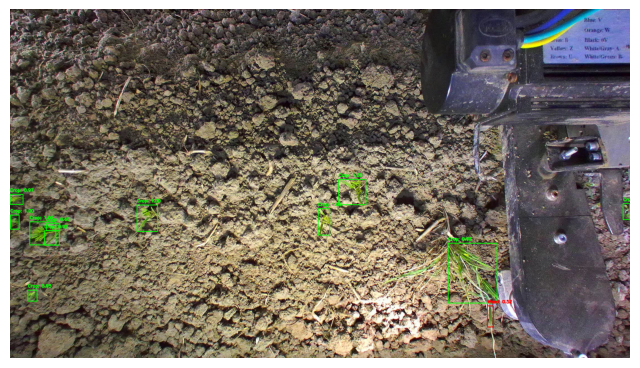

In [13]:
model.eval()

import cv2
import matplotlib.pyplot as plt
import numpy as np

# COCO label names (modify accordingly)
category_names = {1: "Crop", 2: "Weed"}

def plot_predictions(image_path, predictions, threshold=0.5):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    boxes = predictions[0]['boxes'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()

    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:  # Filter low-confidence detections
            x1, y1, x2, y2 = map(int, box)
            class_name = category_names.get(label, "Unknown")
            color = (0, 255, 0) if label == 1 else (255, 0, 0)  # Green for crops, red for weeds

            # Draw rectangle
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
            text = f"{class_name}: {score:.2f}"

            # Put text above rectangle
            cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

def predict(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        predictions = model(image_tensor)

    return predictions

# Run inference
image_path = "/home/remo/Afstudeerproject/AgronomischePerformanceMeting/AnnotationAndTraining/Annotation/images/frame10.jpg"
predictions = predict(image_path)
plot_predictions(image_path, predictions)


## Save model

In [14]:
torch.save(model.state_dict(), "plant_dect_fastercnn.pth")